## Importações

In [1]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf


#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
import keras
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence  import TimeseriesGenerator


# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

# imports para request
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Imports para Greadient
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.ensemble import GradientBoostingRegressor

## Criação do arquivo csv

In [2]:
# Função para atualizar o DataFrame com novos dados
def update_dataframe(df, new_data):
    # Converte a coluna 'Data' para datetime
    df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
    new_data['Data'] = pd.to_datetime(new_data['Data'], dayfirst=True)

    # Encontra a data mais recente no DataFrame existente
    last_date = df['Data'].max()

    # Filtra as novas linhas que são mais recentes do que a última data
    new_rows = new_data[new_data['Data'] > last_date]

    # Concatena os novos dados com o DataFrame existente se houver novas linhas
    if not new_rows.empty:
        updated_df = pd.concat([df, new_rows], ignore_index=True)
    else:
        updated_df = df

    return updated_df

# URL do site IPEADATA
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

# Faz uma requisição GET ao site e captura a resposta
response = requests.get(url)

# Verifica se a requisição foi bem sucedida
if response.status_code == 200:
    # Cria um objeto BeautifulSoup para analisar o HTML
    soup = BeautifulSoup(response.text, 'html.parser')
    # Procura pela tabela no HTML analisado
    table = soup.find('table', {'id': 'grd_DXMainTable'})
    # Usa o pandas para ler a tabela HTML diretamente para um DataFrame
    new_df = pd.read_html(str(table), header=0)[0]

    # Verifica se o arquivo do DataFrame existe e carrega, ou cria um novo DataFrame se não existir
    path = 'ipea.csv'
    try:
        existing_df = pd.read_csv(path)
    except FileNotFoundError:
        existing_df = new_df  # Se o arquivo não existir, considere os dados atuais como o DataFrame existente

    # Atualiza o DataFrame existente com novos dados (carga incremental)
    updated_df = update_dataframe(existing_df, new_df)

    updated_df['Preço - petróleo bruto - Brent (FOB)'] = updated_df['Preço - petróleo bruto - Brent (FOB)']/100

    # Salva o DataFrame atualizado para o arquivo
    updated_df.to_csv(path, index=False,sep=';', decimal=',')

    # Mostra as primeiras linhas do DataFrame atualizado
    updated_df.head()
else:
    print('Falha ao acessar a página: Status Code', response.status_code)

## Criando o DF

In [2]:
# Carregar o DataFrame
df = pd.read_csv('ipea.csv', sep=';', decimal=',')

# Converter a coluna de data para datetime e depois para timestamp Unix
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values(by='Data',ascending=True)
df['Timestamp'] = df['Data'].values.astype('int64') // 10**9


# Escalar a coluna de preços, já que os modelos de DL geralmente funcionam melhor com dados normalizados
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Fechamento_N'] = scaler.fit_transform(df['Preço - petróleo bruto - Brent (FOB)'].values.reshape(-1, 1)).astype('float64')
df.rename(columns={'Preço - petróleo bruto - Brent (FOB)': 'Fechamento'}, inplace=True)


In [3]:
df

,Data,Fechamento,Timestamp,Fechamento_N
11168,1987-05-20,18.63,548467200,-0.858658
11167,1987-05-21,18.45,548553600,-0.861327
11166,1987-05-22,18.55,548640000,-0.859844
11165,1987-05-25,18.60,548899200,-0.859103
11164,1987-05-26,18.63,548985600,-0.858658
...,...,...,...,...
4,2024-05-07,82.69,1715040000,0.091435
3,2024-05-08,82.44,1715126400,0.087727
2,2024-05-09,83.27,1715212800,0.100037
1,2024-05-10,83.39,1715299200,0.101817


## Visualisando os fechamentos

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(df['Data'], df['Fechamento'], label='Petróleo Puro')
plt.legend(loc='best')

plt.show()

## Analise da série temporal

In [ ]:
df_fechamento = df.copy()

In [ ]:
df_fechamento.drop(columns=['Timestamp', 'Fechamento_N'],inplace=True)

In [ ]:
df_fechamento.set_index('Data', inplace=True, drop=True)

In [ ]:
df_fechamento.info()

In [ ]:
df_fechamento.head()

### Decomposição da TimeSeries

In [ ]:
seasonplot = seasonal_decompose(df_fechamento, model='multiplicative', period=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,8))

seasonplot.observed.plot(ax=ax1)
seasonplot.trend.plot(ax=ax2)
seasonplot.seasonal.plot(ax=ax3)
seasonplot.resid.plot(ax=ax4)

plt.tight_layout()

## Testando modelos

### Media Movel

In [ ]:
df_media_movel = df_fechamento.copy()
df_media_movel['MA_janela_10'] = df_media_movel['Fechamento'].rolling(10).mean().shift()
df_media_movel['MA_janela_20'] = df_media_movel['Fechamento'].rolling(20).mean().shift()

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_media_movel['Fechamento'], label='Fechamento')
plt.plot(df_media_movel['MA_janela_10'], label='MA window 10 days')
plt.legend(loc=2)
plt.show()

#### Visualizar os dados dos últimos 300 dias para análise

In [ ]:
limit = 300

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_media_movel['Fechamento'][-limit:], label='Close')
plt.plot(df_media_movel['MA_janela_10'][-limit:], label='MA window 10 days')
plt.plot(df_media_movel['MA_janela_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

In [ ]:
'''

Com esses dados dos últimos 300 dias, vemos que o modelo falhou muito na previsão.

'''

### Média móvel Aritmética

In [ ]:
df_media_movel['MA_window_10_forward_10'] = np.NaN #preechendo com NaN os valores da coluna de MA_window_10_forward_10


In [ ]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [ ]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df_media_movel['Fechamento'].iloc[window_close], df_media_movel['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df_media_movel.iat[index + i, df_media_movel.columns.get_loc('MA_window_10_forward_10')] = mean

In [ ]:
plt.figure(figsize = (15,10))

size = len(df_media_movel)-limit - (len(df_media_movel)-limit)%forward_days

for index in range(size, len(df_media_movel), forward_days):
    plt.plot(df_media_movel['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df_media_movel['Fechamento'][-limit:], color='b', label='Close')
#plt.legend(loc='best')
plt.show()

In [ ]:
'''

Observamos que cada linha vermelha representa a previsão de 10 dias, baseadas nas observações dos 10 dias anteriores.

Vemos que o algoritmo falhou nessa previsão.

'''

### ARIMA

#### ACF e PACF

In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(df_fechamento, lags=50)
plt.show()

In [ ]:
'''
No gráfico ACF (Autocorrelação), observamos que temos um decaimento lento, que se assemelha
a quase uma reta.

Com esse comportamento de decaimento lento, assumimos que trata-se de uma série 
não estarcionária.


'''

In [ ]:
sm.graphics.tsa.plot_pacf(df_fechamento, lags=50)
plt.show()

In [ ]:
'''
Em nosso caso, com o PAFC, 
podemos ver que a order de defasagem da nossa série é observada em 6 lags
'''

#### Analisando a média movel com o desvio padrão

In [ ]:
rolmean = df_fechamento.rolling(window=12).mean() #média móvel em 12 meses (dando a média móvel no nível anual).
rolstd = df_fechamento.rolling(window=12).std()   #Desvio padrão em 12 meses
print(rolmean,rolstd)

In [ ]:
#Plotando a média móvel
orig = plt.plot(df_fechamento, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Média móvel e desvio padrão')
plt.show(block=False)

#### Verificar estacionaridade com Dickey Fuller

Para aumentar ainda mais nossa hipótese de não estacionaridade da série, vamos realizar o teste Dickey-Fuller Aumentado.

H0 (Hipotese Nula)        = Série temporal não é estacionária
H1 (Hipotese Alternativa) = Serie temporal estacionaria

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_fechamento['Fechamento'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

Para que uma série temporal seja estacionária, seu teste ADCF:

- valor p alto (de acordo com a hipótese nula) (valor p no máximo pode ser 1)

- Os valores críticos em intervalos de confiança de 1%,5%,10% devem ser o mais próximo possível das Estatísticas de Teste.
Portanto, podemos dizer com segurança que nossa Série Temporal no momento não é estacionária.

#### Transformando a série e estacionária

Subtração dos dados transformados pelo log pela média móvel

In [ ]:
#Estimating trend
indexedDataset_logScale = np.log(df_fechamento) #Transformação logarítma
plt.plot(indexedDataset_logScale)

In [ ]:
# Calculando a média móvel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [ ]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

In [ ]:
# Função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Fechamento'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(datasetLogScaleMinusMovingAverage)

Remover a tendência e tornar a série mais estacionária

In [ ]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() #diferença entre o valor anterior e o atual
plt.plot(datasetLogDiffShifting)

In [ ]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

Teste de Correlação Parcial

In [ ]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=3)
lag_pacf = pacf(datasetLogDiffShifting, nlags=3, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

In [ ]:
#AR Model
model = ARIMA(datasetLogDiffShifting, order=(1,1,1))#(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Fechamento'])**2))
print('Plotting AR model')

In [ ]:
from sklearn.metrics import mean_absolute_error

# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = datasetLogDiffShifting.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = indexedDataset_logScale['Fechamento'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['Fechamento'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

In [ ]:
'''
Com esse valor de MAPE, há indicações de que as previsões do modelo 
estão muito longe de valores reais
'''

### Prophet

In [ ]:
df[['ds','y']] = df[['Data','Fechamento']]
df.head()

In [ ]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

In [ ]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=2, freq='D')
previsao = modelo.predict(dataFramefuture)
previsao.head()

In [ ]:
modelo.plot(previsao, figsize=(20,6))
plt.plot(test_data['ds'], test_data['y'], '.r')

In [ ]:
from prophet.plot import add_changepoints_to_plot

modelo_changepoints = Prophet(n_changepoints=5)
modelo_changepoints.fit(train_data)
dataFramefuture = modelo_changepoints.make_future_dataframe(periods=2, freq='D')
previsao_changepoints = modelo_changepoints.predict(dataFramefuture)
previsao_changepoints.head()

In [ ]:
fig = modelo_changepoints.plot(previsao_changepoints, figsize=(20,6))
a = add_changepoints_to_plot(fig.gca(), modelo_changepoints, previsao_changepoints)

In [ ]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

### LSTM

In [4]:
close_data = df['Fechamento'].values
close_data = close_data.reshape(-1,1) #Transformar em array

Normalizando os dados

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

Treino e Teste

In [6]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Data'][:split]
date_test = df['Data'][split:]

print(len(close_train))
print(len(close_test))

8935
2234


In [7]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [8]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 10
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0185 - mean_squared_error: 0.0185
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.6116e-04 - mean_squared_error: 5.6116e-04
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.1548e-04 - mean_squared_error: 5.1548e-04
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.5727e-04 - mean_squared_error: 2.5727e-04
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.5240e-04 - mean_squared_error: 2.5240e-04
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.6252e-04 - mean_squared_error: 3.6252e-04
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.6645e-04 - mean_squared_error: 2.6645e-04
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.4277e-04 - mean_squared_error: 2.4277e-04
Epoch 9/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.0074e-04 - mean_squared_error: 3.0074e-04
Epoch 10/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.5298e-04 

In [9]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

2224/2224 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step - loss: 1.9668e-04 - mean_squared_error: 1.9668e-04
Erro Quadrático Médio 0.0003383903531357646


In [10]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')

2224/2224 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
MAPE: 4.0441


In [11]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.01839538945322345


In [12]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições Petroleo",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

2224/2224 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


Validando com suavização da série temporal

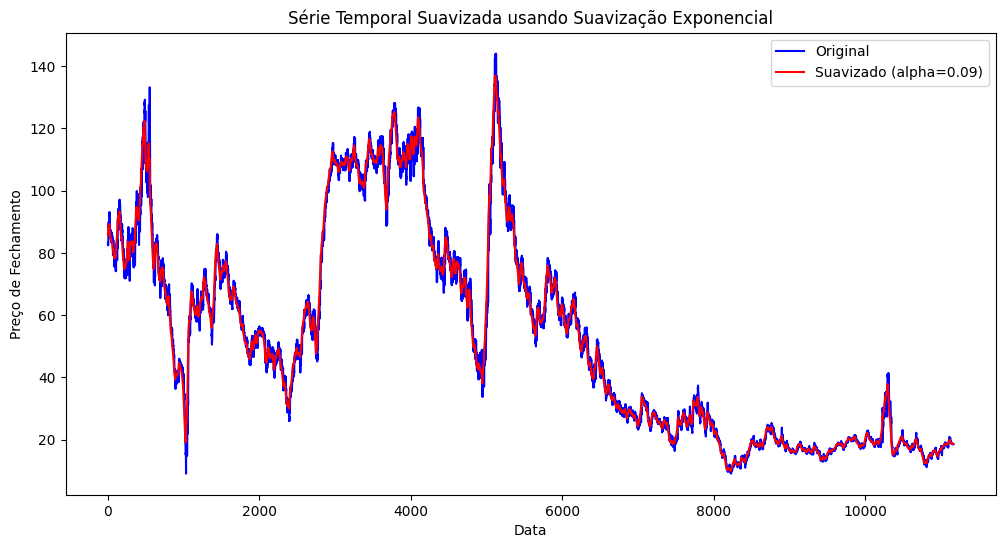

In [13]:
# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df['Smoothed_Close'] = df['Fechamento'].ewm(alpha=alpha, adjust=False).mean()

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Fechamento'], label='Original', color='blue')
plt.plot(df.index, df['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [14]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.08070877999479
p-value: 0.2523421110160892
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.08070877999479
Valor-p: 0.2523421110160892
Valores Críticos:
   1%: -3.4309373570405923
   5%: -2.8617995797890816
   10%: -2.5669081692030327


In [15]:
close_data = df['Smoothed_Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [16]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Data'][:split]
date_test = df['Data'][split:]

print(len(close_train))
print(len(close_test))

8935
2234


In [17]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [19]:
np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 10
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0435 - mean_squared_error: 0.0435
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5187e-05 - mean_squared_error: 5.5187e-05
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5482e-05 - mean_squared_error: 7.5482e-05
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0732e-04 - mean_squared_error: 1.0732e-04
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2704e-04 - mean_squared_error: 1.2704e-04
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7868e-04 - mean_squared_error: 1.7868e-04
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4236e-04 - mean_squared_error: 2.4236e-04
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3701e-04 - mean_squared_error: 1.3701e-04
Epoch 9/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5328e-04 - mean_squared_error: 1.5328e-04
Epoch 10/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8795e-05 

In [20]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%")

2229/2229 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
MAPE: 2.65%


In [21]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

2229/2229 ━━━━━━━━━━━━━━━━━━━━ 2s 833us/step - loss: 1.5990e-04 - mean_squared_error: 1.5990e-04
Erro Quadrático Médio: 0.00023884442634880543


In [22]:
# O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.015454592403192179


In [23]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições Petróleo",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

2229/2229 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


## Forecasting

In [24]:
close_data = close_data.reshape((-1))


# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas

def predict_dates(num_prediction):
    last_date = df['Data'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [25]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast Disney",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [26]:
df = pd.DataFrame(df)
df_past = df[['Data','Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Data'] = pd.to_datetime(df_past['Data'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.head(3)

,Data,Actual,Forecast
11168,1987-05-20,18.630000,NaN
11167,1987-05-21,18.613800,NaN
11166,1987-05-22,18.608058,NaN


In [27]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

In [28]:
df_future = pd.DataFrame(columns=['Data', 'Actual', 'Forecast'])
df_future['Data'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.head()

,Data,Actual,Forecast
0,2024-05-13,NaN,85.889997
1,2024-05-14,NaN,88.593269
2,2024-05-15,NaN,88.930866
3,2024-05-16,NaN,89.383408
4,2024-05-17,NaN,89.968520


In [29]:
# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Data')
results.head()

,Actual,Forecast
Data,,
1987-05-20,18.630000,NaN
1987-05-21,18.613800,NaN
1987-05-22,18.608058,NaN
1987-05-25,18.607333,NaN
1987-05-26,18.609373,NaN


In [ ]:
results.tail()

In [30]:
results2024 =  results.loc['2024-01-01':]


In [31]:
plot_data = [
    go.Scatter(
        x=results2024.index,
        y=results2024['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2024.index,
        y=results2024['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast Petroleo'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

## Preparando streamlit

In [ ]:
import pickle

with open('modelo_brent.pkl', 'wb') as file:
    pickle.dump(model, file)

carregar o modelo

In [ ]:
with open('modelo_brent.pkl', 'rb') as file_2:
    modelo_brent = pickle.load(file_2)

prev = modelo_brent.predict(test_generator)

In [ ]:
prev